In [9]:
!pip install pretrainedmodels

  Using cached https://files.pythonhosted.org/packages/cc/ab/85d8da5c9a45e072301beb37ad7f833cd344e04c817d97e0cc75681d248f/munch-2.5.0-py2.py3-none-any.whl
You are using pip version 10.0.1, however version 20.1b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
from PIL import Image
import shutil

import numpy as np
import matplotlib.pyplot as plot
import pandas as pd

import torch
import fastai
from fastai import vision
from fastai.vision import *


import pretrainedmodels as pm

In [11]:
# !pip freeze

In [12]:
# !pip install -U fastai

In [13]:
# ! conda config --set ssl_verify no && conda install -y -c pytorch pytorch=1.4.0 torchvision cuda92

In [14]:
# !pip install torch==1.4.0
# !pip install fastai

In [15]:
%matplotlib inline

In [16]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

## Creating Pseudo-Labels for the Extra Images

In [17]:
transform_kwargs = {"do_flip": True,
                    "flip_vert": True,
                    "max_rotate": 180,
                    "max_zoom": 1.1,
                    "max_lighting": 0.2,
                    "max_warp": 0.2,
                    "p_affine": 0.75,
                    "p_lighting": 0.7}
        
transforms = vision.get_transforms(**transform_kwargs)

data_bunch_kwargs = {"path": "./data/train",
                     "train": "train",
                     "valid_pct": 0.1,
                     "size": 448,
                     "bs": 16,
                     "ds_tfms": transforms,
                     "test": "./data/extraimages/extraimages"}

get_transforms()

image_data_bunch = (vision.ImageDataBunch 
                          .from_folder(**data_bunch_kwargs)
                          .normalize())

In [20]:
shutil.copytree("./data/models/", "./models")

'./models'

### Use our pretrained model to predict the labels for our extra images

In [23]:
# _base_arch = lambda arg: pm.se_resnext101_32x4d(num_classes=5, pretrained=None)
# learner = vision.cnn_learner(image_data_bunch, base_arch=_base_arch, pretrained=False, metrics=vision.error_rate, model_dir="/models/se-resnext101-32x4d")
# _ = learner.load("best-model-stage-2")

FileNotFoundError: [Errno 2] No such file or directory: '/models/se-resnext101-32x4d/best-model-stage-2.pth'

In [8]:
predicted_probabilities, _ = learner.TTA(ds_type=fastai.basic_data.DatasetType.Test)

In [9]:
predicted_class_probabilities, _predicted_classes = predicted_probabilities.max(dim=1)
class_labels = np.array(['cbb','cbsd','cgm','cmd','healthy'])
predicted_class_labels = class_labels[_predicted_classes]


## Creating a new training data set

Once we have the pseudo-labels and predicted probabilities that these pseudo-labels are correct we need to decide which of the extra images we want to include in our new, larger training data set. Basic idea is to choose a decision threshold and then only include the extra images where our original model was highly confident in the predicted pseduo-label.

In [10]:
shutil.copytree("../input/cassava-disease/train/train/", "./data/train")
shutil.copytree("../input/cassava-disease/test/test/", "./data/test")

threshold = 0.95  # only include pseudo-labeled images where model is sufficiently confident in its prediction
filenames = [item.name for item in learner.data.test_ds.items]
for predicted_class_label, predicted_class_probability, filename in zip(predicted_class_labels, predicted_class_probabilities, filenames):
    if predicted_class_probability > threshold:
        shutil.copy(f"../input/cassava-disease/extraimages/extraimages/{filename}", f"./data/train/{predicted_class_label}/{filename}")

In [11]:
transform_kwargs = {"do_flip": True,
                    "flip_vert": True,
                    "max_rotate": 180,
                    "max_zoom": 1.1,
                    "max_lighting": 0.2,
                    "max_warp": 0.2,
                    "p_affine": 0.75,
                    "p_lighting": 0.7}
        
transforms = vision.get_transforms(**transform_kwargs)

data_bunch_kwargs = {"path": "./data/train",
                     "train": "train",
                     "valid_pct": 0.1,
                     "size": 448,
                     "bs": 16,
                     "ds_tfms": transforms,
                     "test": "../test"}

image_data_bunch = (vision.ImageDataBunch
                          .from_folder(**data_bunch_kwargs)
                          .normalize())

## Train the model on new training data set

In [12]:
_base_arch = lambda arg: pm.se_resnext101_32x4d(num_classes=5, pretrained=None)
learner = vision.cnn_learner(image_data_bunch, base_arch=_base_arch, pretrained=False, metrics=vision.error_rate, model_dir="/kaggle/working/models/se-resnext101-32x4d")
_ = learner.load("best-model-stage-2")

In [13]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


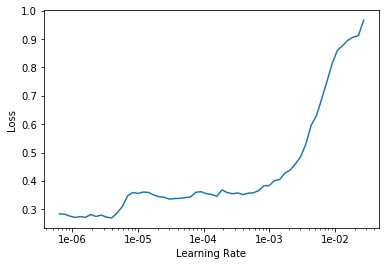

In [14]:
(learner.recorder
        .plot())

In [15]:
_save_model_kwargs = {"every": "improvement",
                      "monitor": "valid_loss",
                      "name": "best-model-stage-3"}
_save_model = (fastai.callbacks
                     .SaveModelCallback(learner, **_save_model_kwargs))
learner.fit_one_cycle(15, max_lr=slice(None, 1e-6, None), callbacks=[_save_model])

epoch,train_loss,valid_loss,error_rate,time
0,0.322894,0.147282,0.048077,07:12
1,0.317687,0.135908,0.044471,07:14
2,0.318753,0.128661,0.039663,07:13
3,0.341035,0.128646,0.043269,07:13
4,0.277657,0.136997,0.045673,07:14
5,0.336265,0.122999,0.042067,07:13
6,0.297175,0.129257,0.044471,07:13
7,0.294812,0.134234,0.050481,07:13


Better model found at epoch 0 with valid_loss value: 0.1472819447517395.
Better model found at epoch 1 with valid_loss value: 0.13590756058692932.
Better model found at epoch 2 with valid_loss value: 0.1286608725786209.
Better model found at epoch 3 with valid_loss value: 0.12864600121974945.
Better model found at epoch 5 with valid_loss value: 0.12299854308366776.


## Make predictions using TTA

In [16]:
predicted_probabilities, _ = learner.TTA(ds_type=fastai.basic_data.DatasetType.Test)

## Create a submission

In [17]:
_, _predicted_classes = predicted_probabilities.max(dim=1)
_predicted_class_labels = class_labels[_predicted_classes]

_filenames = np.array([item.name for item in image_data_bunch.test_ds.items])

submission = (pd.DataFrame
                .from_dict({'Category': _predicted_class_labels,'Id': _filenames}))

In [18]:
submission.to_csv('submission-using-pseudo-labels.csv', header=True, index=False)

In [19]:
shutil.rmtree("./data") # remove unnecessary output files!